<a href="https://colab.research.google.com/github/Pari510/website/blob/main/Task2b_Hyper_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cuisine Classification Using NLP Models: A Comparative Study

This project aims to classify recipes into their respective cuisines using various natural language processing (NLP) models. The process involves data preprocessing, model training, hyperparameter optimization, and evaluation using multiple pre-trained models including DistilBERT, BERT (base and large), RoBERTa, and GPT-2. The performance of these models is compared to identify the most effective model for cuisine classification. Interactive components are also implemented using Gradio for an intuitive user interface to explore and classify recipes.

## Setup and Installation of Required Packages

In [1]:
!pip install transformers datasets scikit-learn
!pip install optuna
!pip install optuna-integration
!pip install torch
!pip install python-docx
!pip install accelerate -U
!pip install gradio

## Importing Required Libraries

In [2]:
# Importing libraries for data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast
from google.colab import files

# Importing libraries for machine learning and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Importing Hugging Face Transformers for NLP tasks
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    GPT2Tokenizer, GPT2ForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    Trainer, TrainingArguments
)

# Importing datasets library for managing datasets
from datasets import Dataset, DatasetDict

# Importing additional libraries for numerical operations and visualization
import numpy as np
import seaborn as sns

# Importing PyTorch and optimization tools
import torch
import torch.optim as optim
from tqdm import tqdm

# Importing Optuna for hyperparameter optimization
import optuna

# Import Gradio
import gradio as gr

## Uploading and Loading Datasets


In [3]:
# Uploading files
uploaded = files.upload()

# Defining paths for the training and test data
training_data_path = 'Recipes_Training.csv'
test_data_path = 'Recipes_Test.csv'

# Loading the datasets into Pandas DataFrames
training_df = pd.read_csv(training_data_path, delimiter=';')
test_df = pd.read_csv(test_data_path, delimiter=';')

Saving Recipes_Test.csv to Recipes_Test (1).csv
Saving Recipes_Training.csv to Recipes_Training (1).csv


## Data Analysis and Visualization

In [4]:
# Function to Display DataFrame Information
def display_dataframe_info(df, df_name):
    """
    Prints the information and first few rows of a given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to display information for.
    df_name (str): The name of the DataFrame.
    """
    print(f"\nInformationen zum {df_name} DataFrame:")
    print(df.info())
    print(f"\nErste Zeilen des {df_name} DataFrame:")
    print(df.head())
    print("\n")

# Function to Get Top Ingredients for Each Cuisine
def get_top_ingredients_by_cuisine(cuisine):
    """
    Returns the top 10 most common ingredients for a specified cuisine.

    Parameters:
    cuisine (str): The name of the cuisine to analyze.

    Returns:
    List[Tuple[str, int]]: A list of tuples containing the top ingredients and their counts.
    """
    # Filter the training data for the specified cuisine
    cuisine_data = training_df[training_df['cuisine'] == cuisine]

    # Initialize a list to store all ingredients for this cuisine
    all_ingredients = []

    # Loop through the ingredients lists, parse them, and extend the all_ingredients list
    for ingredients_list in cuisine_data['ingredients']:
        ingredients = ast.literal_eval(ingredients_list)
        all_ingredients.extend(ingredients)

    # Count the frequency of each ingredient
    ingredient_counts = Counter(all_ingredients)

    # Return the top 10 most common ingredients
    return ingredient_counts.most_common(10)


Informationen zum Trainings DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           8000 non-null   int64 
 1   cuisine      8000 non-null   object
 2   ingredients  8000 non-null   object
dtypes: int64(1), object(2)
memory usage: 187.6+ KB
None

Erste Zeilen des Trainings DataFrame:
      id      cuisine                                        ingredients
0  25693  southern_us  ['plain flour', 'ground pepper', 'salt', 'toma...
1  22213       indian        ['water', 'vegetable oil', 'wheat', 'salt']
2  13162       indian  ['black pepper', 'shallots', 'cornflour', 'cay...
3   3735      italian  ['sugar', 'pistachio nuts', 'white almond bark...
4  16903      mexican  ['olive oil', 'purple onion', 'fresh pineapple...



Informationen zum Test DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data

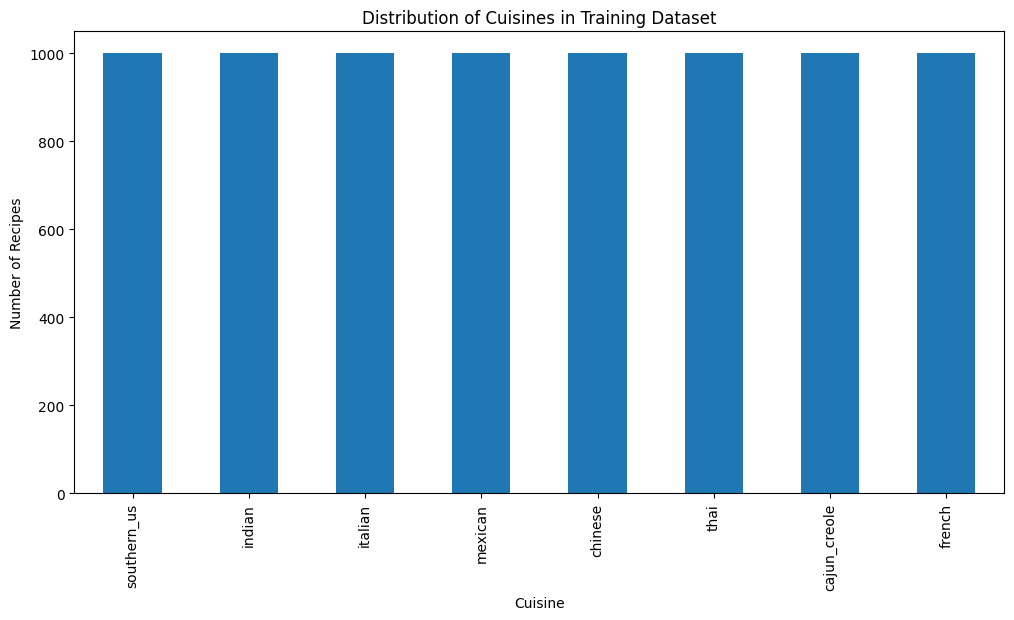

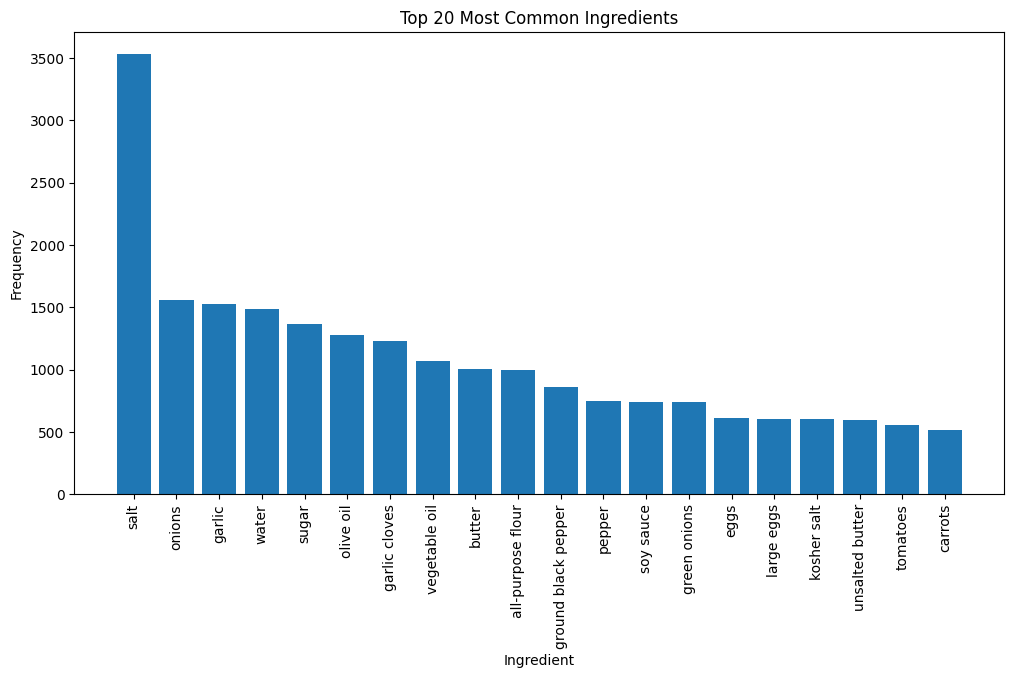

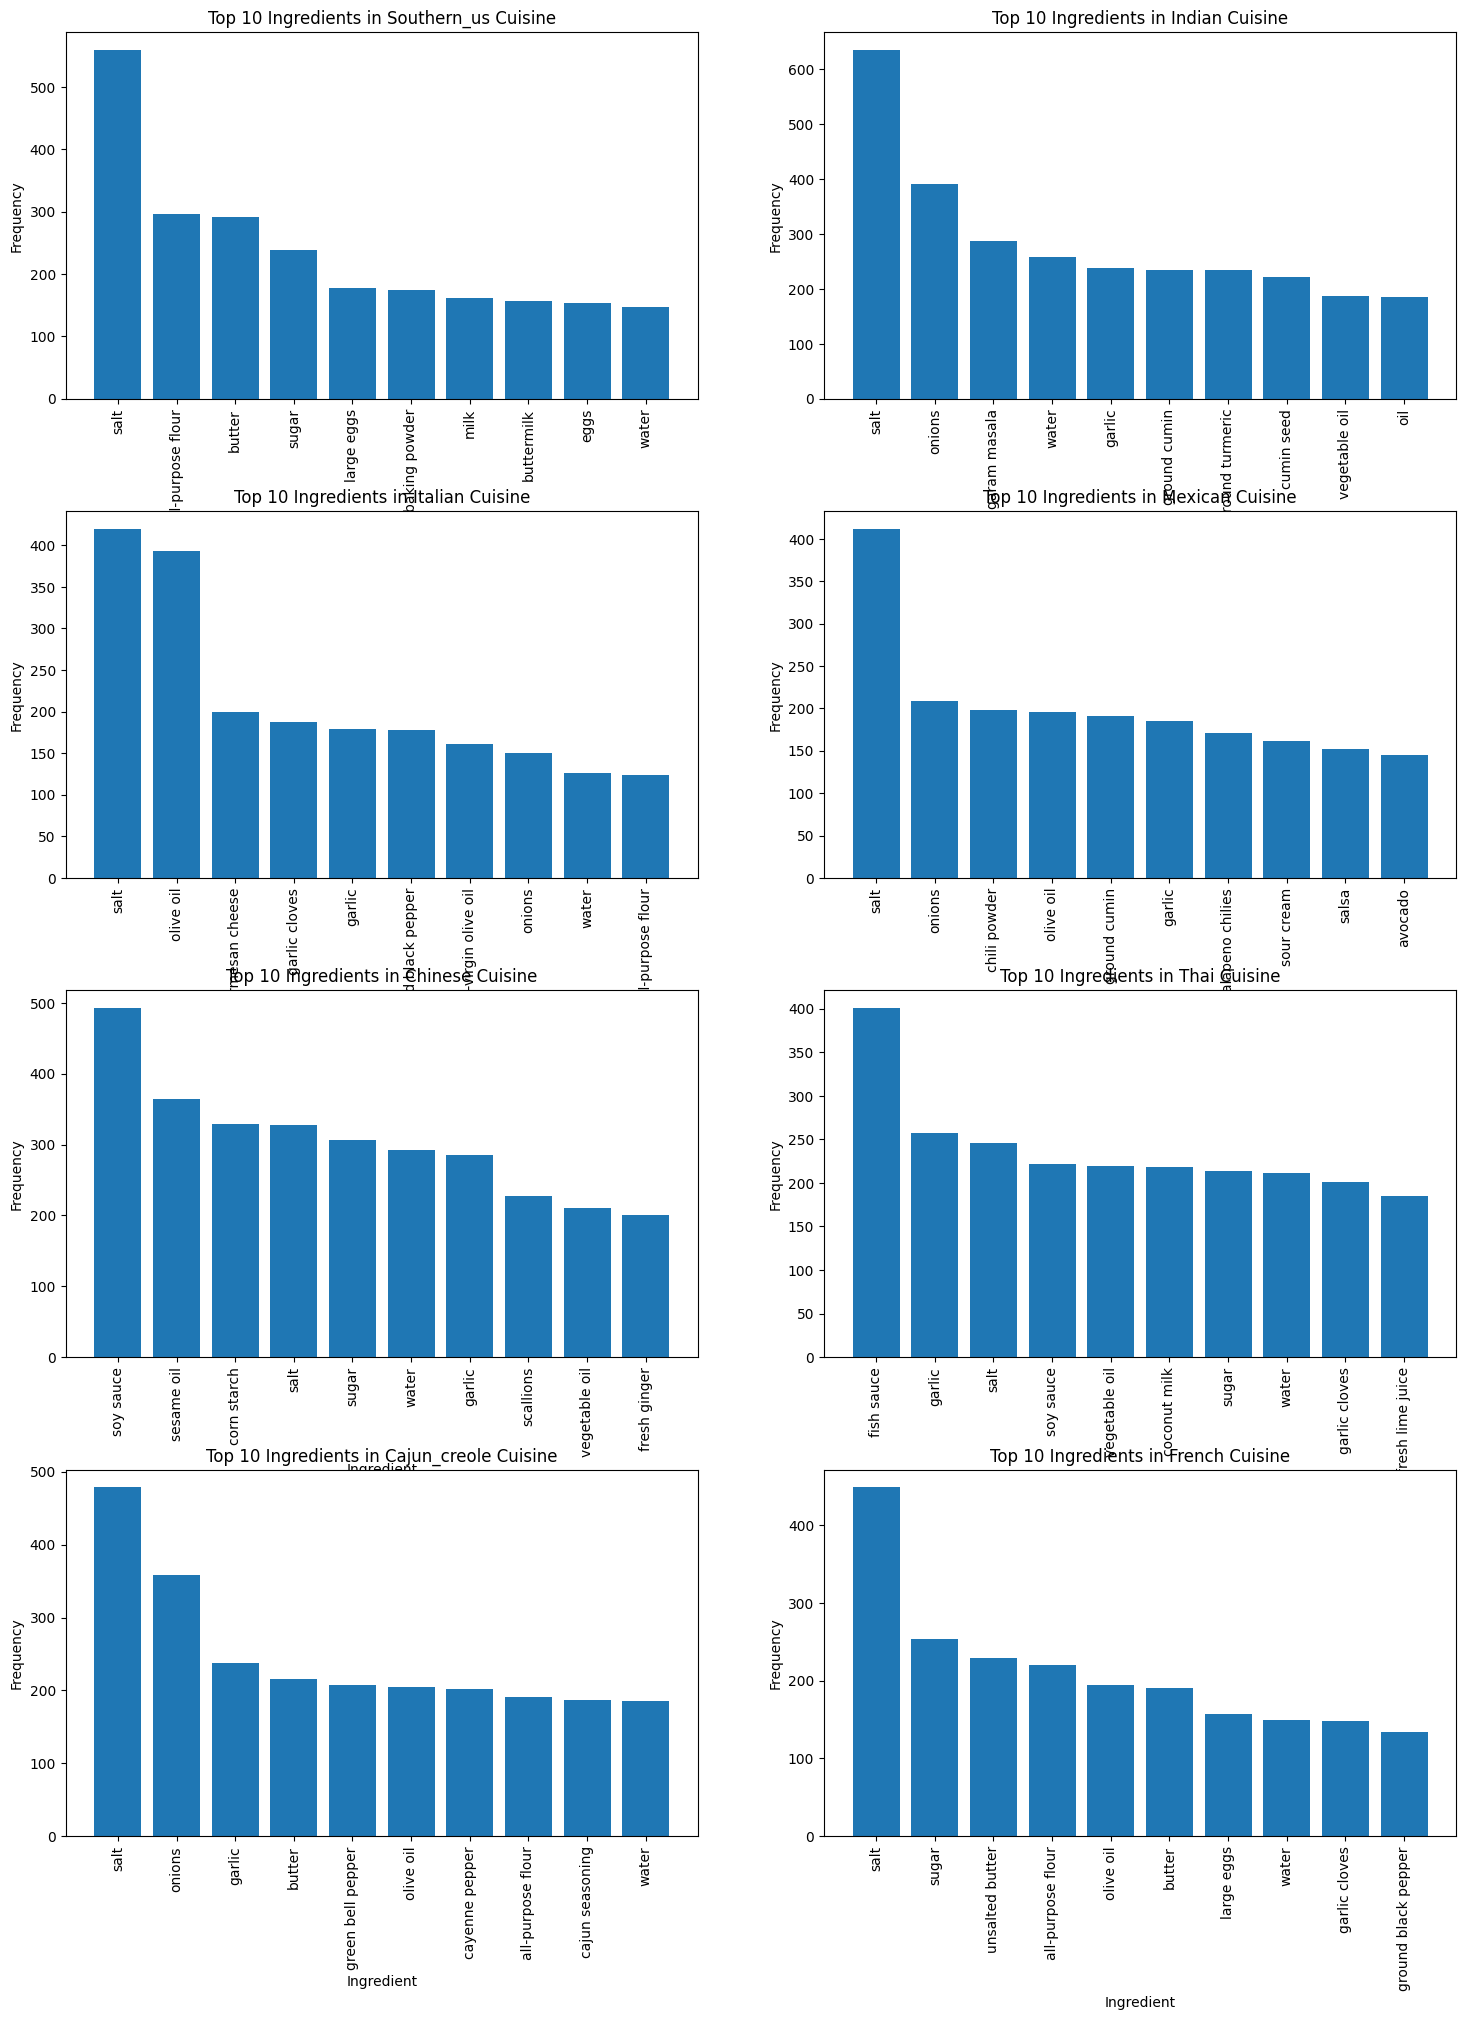

In [5]:
# Displaying information and first few rows of the training and test DataFrames
display_dataframe_info(training_df, "Trainings")
display_dataframe_info(test_df, "Test")

# Distribution of Cuisines in the Training Dataset
cuisine_counts = training_df['cuisine'].value_counts()
plt.figure(figsize=(12, 6))
cuisine_counts.plot(kind='bar')
plt.title('Distribution of Cuisines in Training Dataset')
plt.xlabel('Cuisine')
plt.ylabel('Number of Recipes')
plt.show()

# Most Common Ingredients
all_ingredients = []
for ingredients_list in training_df['ingredients']:
    ingredients = ast.literal_eval(ingredients_list)
    all_ingredients.extend(ingredients)

ingredient_counts = Counter(all_ingredients)

# Top 20 Most Common Ingredients
top_ingredients = ingredient_counts.most_common(20)
ingredients, counts = zip(*top_ingredients)
plt.figure(figsize=(12, 6))
plt.bar(ingredients, counts)
plt.title('Top 20 Most Common Ingredients')
plt.xlabel('Ingredient')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


# Top Ingredients for Each Cuisine
cuisines = training_df['cuisine'].unique()
top_ingredients_by_cuisine = {cuisine: get_top_ingredients_by_cuisine(cuisine) for cuisine in cuisines}

# Plotting Top Ingredients for Each Cuisine
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
fig.tight_layout(pad=6.0)

for ax, (cuisine, top_ingredients) in zip(axes.flatten(), top_ingredients_by_cuisine.items()):
    ingredients, counts = zip(*top_ingredients)
    ax.bar(ingredients, counts)
    ax.set_title(f'Top 10 Ingredients in {cuisine.capitalize()} Cuisine')
    ax.set_xlabel('Ingredient')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=90)
plt.show()

## Splitting Training and Validation Data

In [6]:
# Splitting Training and Validation Data
train_df, val_df = train_test_split(
    training_df,
    test_size=0.2,
    stratify=training_df['cuisine'],
    random_state=42
)

## Converting Datasets to Hugging Face Dataset Format

In [7]:
# Convert DataFrames to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
datasets = DatasetDict({"train": train_dataset, "val": val_dataset})

# Convert test DataFrame to Hugging Face Dataset format
test_dataset = Dataset.from_pandas(test_df)

# Maximum length for padding and truncation
max_length = 10  # Adjust as needed

# Create label conversion mapping
label2id = {label: i for i, label in enumerate(training_df['cuisine'].unique())}
id2label = {i: label for label, i in label2id.items()}

## Preparing Text and Labels for Model Training

### Preprocess Function

In [8]:
# Define maximum length for token sequences
max_length = 128

def preprocess_function(examples):
    """
    Tokenizes the input text and converts the labels to numerical IDs.

    Parameters:
    examples (dict): A dictionary containing 'ingredients' and 'cuisine' keys.

    Returns:
    dict: A dictionary with tokenized inputs and numerical labels.
    """
    inputs = tokenizer(examples['ingredients'], padding='max_length', truncation=True, max_length=max_length)
    inputs['labels'] = [label2id[label] for label in examples['cuisine']]
    return inputs

### Create Optimizer

In [9]:
def create_optimizer(model, learning_rate, weight_decay):
    """
    Creates an AdamW optimizer for model training.

    Parameters:
    model (nn.Module): The model to optimize.
    learning_rate (float): The learning rate for the optimizer.
    weight_decay (float): The weight decay for the optimizer.

    Returns:
    torch.optim.AdamW: The optimizer.
    """
    return torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

### Compute Metrics

In [10]:
def compute_metrics(p):
    """
    Computes the accuracy of the model predictions.

    Parameters:
    p (EvalPrediction): An object containing predictions and label IDs.

    Returns:
    dict: A dictionary with the accuracy score.
    """
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

## Train Model Function

In [15]:
def train_model(model_name, model_class, tokenizer_class, num_labels, learning_rate=2e-5, batch_size=16, weight_decay=0.01, num_epochs=1, add_pad_token=False):
    """
    Trains a model with specified hyperparameters and evaluates its performance.

    Parameters:
    model_name (str): The name of the pre-trained model.
    model_class: The class of the model to be trained.
    tokenizer_class: The tokenizer class corresponding to the model.
    num_labels (int): The number of labels for classification.
    learning_rate (float): The learning rate for the optimizer. Default is 2e-5.
    batch_size (int): The batch size for training and evaluation. Default is 16.
    weight_decay (float): The weight decay for the optimizer. Default is 0.01.
    num_epochs (int): The number of training epochs. Default is 1.
    add_pad_token (bool): Whether to add a padding token to the tokenizer. Default is False.

    Returns:
    model: The trained model.
    dict: The evaluation results of the model.
    """
    global tokenizer
    tokenizer = tokenizer_class.from_pretrained(model_name)

    if add_pad_token:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    tokenized_datasets = datasets.map(preprocess_function, batched=True)

    model = model_class.from_pretrained(model_name, num_labels=num_labels)

    if add_pad_token:
        model.resize_token_embeddings(len(tokenizer))
        model.config.pad_token_id = tokenizer.pad_token_id

    model.to(device)
    optimizer = create_optimizer(model, learning_rate, weight_decay)

    training_args = TrainingArguments(
        output_dir='./results',
        eval_strategy="epoch",
        logging_strategy="steps",
        logging_steps=10,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["val"],
        optimizers=(optimizer, None),
        compute_metrics=compute_metrics
    )

    # Check the labels
    for i, batch in enumerate(trainer.get_train_dataloader()):
        labels = batch['labels']
        assert labels.min() >= 0 and labels.max() < num_labels, f"Labels are out of range in batch {i}"
        assert labels.dtype == torch.int64, f"Labels are not int64 in batch {i}"

    trainer.train()

    # Predictions and metrics calculation
    val_predictions = trainer.predict(tokenized_datasets["val"]).predictions
    val_predictions = np.argmax(val_predictions, axis=1)
    val_labels = tokenized_datasets["val"]['labels']

    # Classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(val_labels, val_predictions, target_names=list(label2id.keys())))

    # Confusion matrix
    cm = confusion_matrix(val_labels, val_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(label2id.keys()), yticklabels=list(label2id.keys()), cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Evaluation results
    eval_results = trainer.evaluate()

    return model, eval_results

## Training Models with Standard Hyperparameters

### Check for GPU Availability:

In [12]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Define Number of Classes:

In [13]:
# Number of classes
num_labels = len(training_df['cuisine'].unique())

## Train models with standard hyperparameters

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.786100,1.753903,0.386250


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.26      0.40      0.32       200
      indian       0.46      0.30      0.36       200
     italian       0.36      0.53      0.43       200
     mexican       0.56      0.32      0.41       200
     chinese       0.44      0.52      0.48       200
        thai       0.40      0.41      0.40       200
cajun_creole       0.45      0.35      0.40       200
      french       0.32      0.27      0.29       200

    accuracy                           0.39      1600
   macro avg       0.41      0.39      0.39      1600
weighted avg       0.41      0.39      0.39      1600



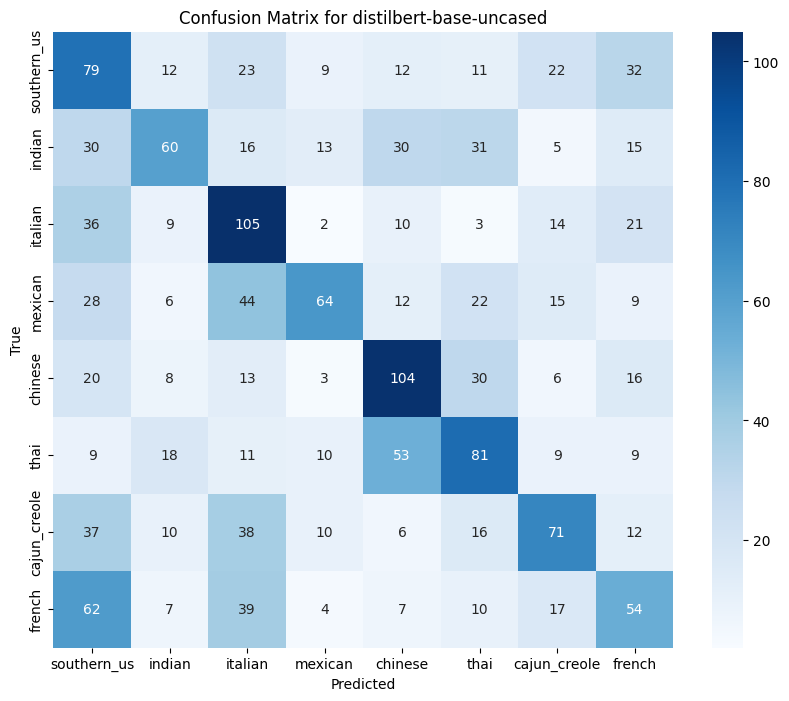

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.793900,1.759361,0.381250


Classification Report for bert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.27      0.27      0.27       200
      indian       0.43      0.46      0.44       200
     italian       0.37      0.46      0.41       200
     mexican       0.41      0.28      0.34       200
     chinese       0.49      0.53      0.50       200
        thai       0.43      0.43      0.43       200
cajun_creole       0.36      0.37      0.37       200
      french       0.28      0.26      0.27       200

    accuracy                           0.38      1600
   macro avg       0.38      0.38      0.38      1600
weighted avg       0.38      0.38      0.38      1600



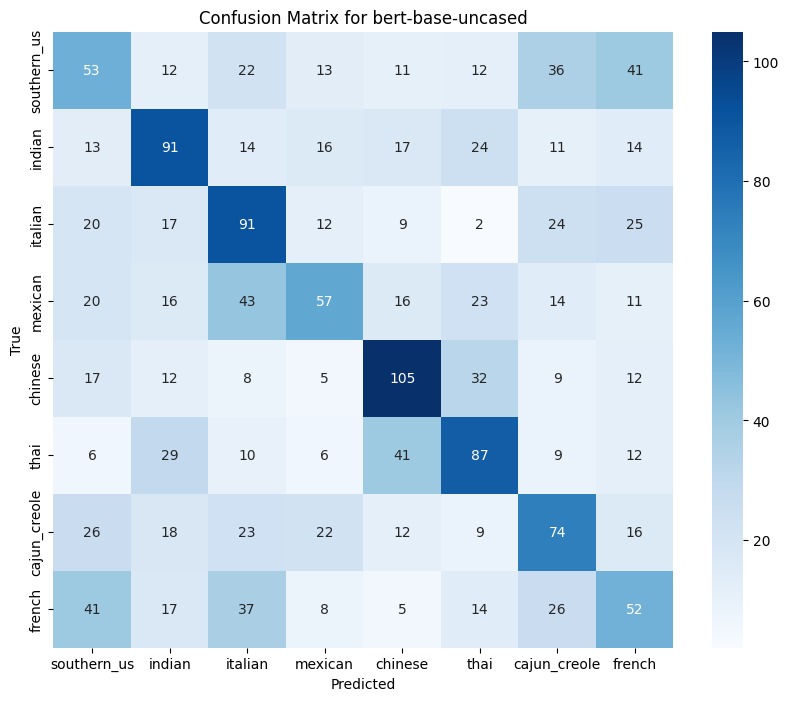

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.699300,1.685997,0.390000


Classification Report for bert-large-uncased:
              precision    recall  f1-score   support

 southern_us       0.27      0.32      0.29       200
      indian       0.35      0.44      0.39       200
     italian       0.43      0.40      0.41       200
     mexican       0.48      0.41      0.45       200
     chinese       0.49      0.47      0.48       200
        thai       0.45      0.39      0.42       200
cajun_creole       0.38      0.33      0.35       200
      french       0.33      0.35      0.34       200

    accuracy                           0.39      1600
   macro avg       0.40      0.39      0.39      1600
weighted avg       0.40      0.39      0.39      1600



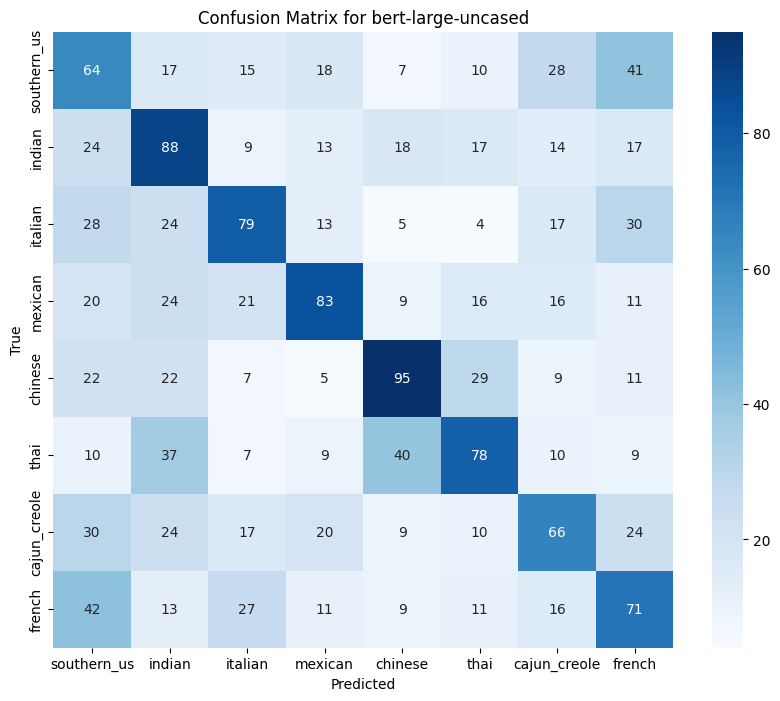

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.088800,2.079751,0.125000


Classification Report for roberta-base:
              precision    recall  f1-score   support

 southern_us       0.00      0.00      0.00       200
      indian       0.00      0.00      0.00       200
     italian       0.00      0.00      0.00       200
     mexican       0.12      1.00      0.22       200
     chinese       0.00      0.00      0.00       200
        thai       0.00      0.00      0.00       200
cajun_creole       0.00      0.00      0.00       200
      french       0.00      0.00      0.00       200

    accuracy                           0.12      1600
   macro avg       0.02      0.12      0.03      1600
weighted avg       0.02      0.12      0.03      1600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


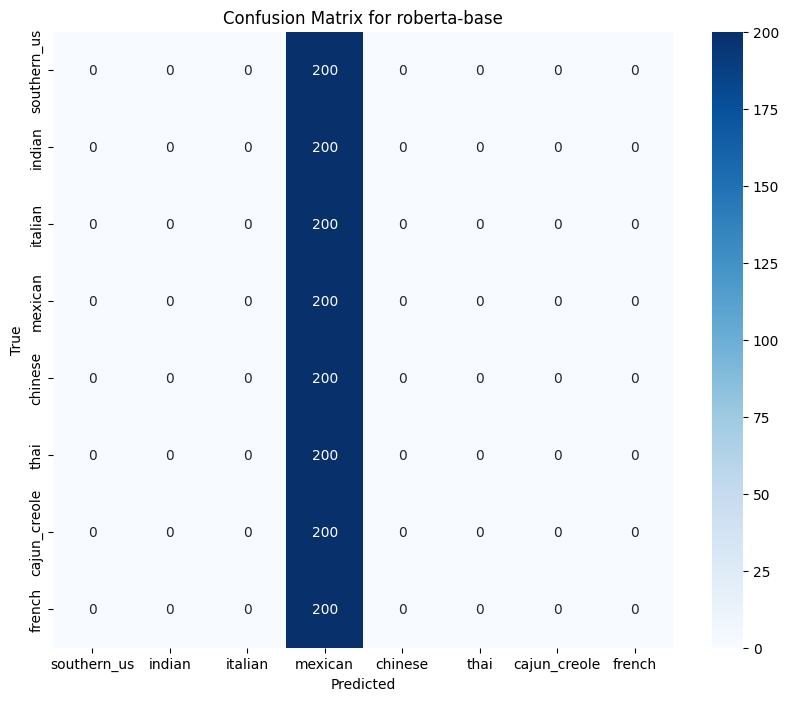

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.983500,1.940781,0.293125


Classification Report for gpt2:
              precision    recall  f1-score   support

 southern_us       0.24      0.16      0.19       200
      indian       0.31      0.23      0.26       200
     italian       0.25      0.28      0.26       200
     mexican       0.28      0.54      0.37       200
     chinese       0.32      0.41      0.36       200
        thai       0.34      0.22      0.27       200
cajun_creole       0.34      0.31      0.32       200
      french       0.28      0.20      0.24       200

    accuracy                           0.29      1600
   macro avg       0.30      0.29      0.28      1600
weighted avg       0.30      0.29      0.28      1600



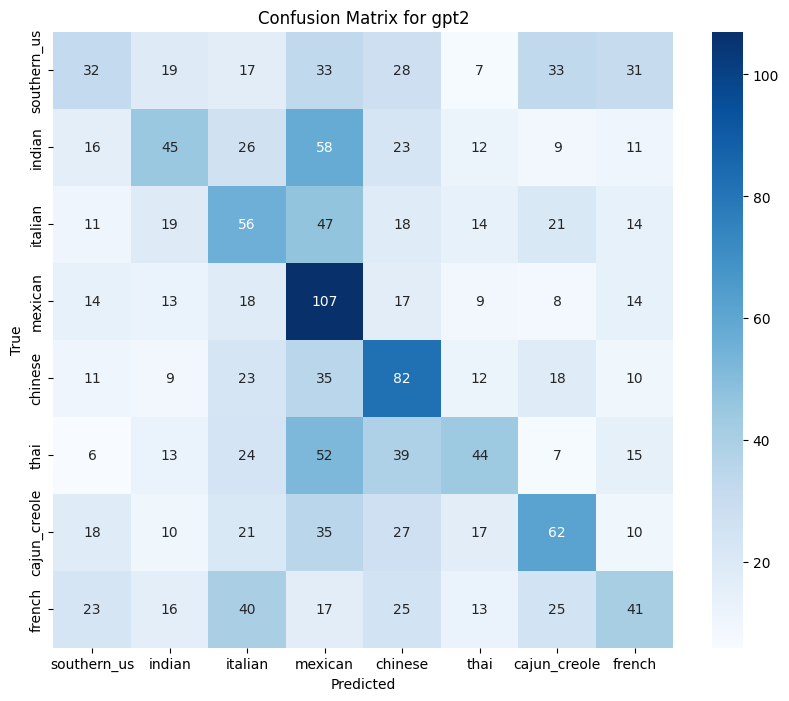

In [16]:
# DistilBERT Model
distilbert_model, _ = train_model(
    'distilbert-base-uncased',
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    num_labels,
    num_epochs=1
)

# BERT Base Model
bert_base_model, _ = train_model(
    'bert-base-uncased',
    BertForSequenceClassification,
    BertTokenizer,
    num_labels,
    num_epochs=1
)

# BERT Large Model
bert_large_model, _ = train_model(
    'bert-large-uncased',
    BertForSequenceClassification,
    BertTokenizer,
    num_labels,
    num_epochs=1
)

# RoBERTa Model
roberta_model, _ = train_model(
    'roberta-base',
    RobertaForSequenceClassification,
    RobertaTokenizer,
    num_labels,
    num_epochs=2
)

# GPT-2 Model
gpt2_model, _ = train_model(
    'gpt2',
    GPT2ForSequenceClassification,
    GPT2Tokenizer,
    num_labels,
    num_epochs=1,
    add_pad_token=True
)

## Hyperparameter Optimization with Optuna

[I 2024-06-09 08:44:18,034] A new study created in memory with name: no-name-1c3585a4-5f4d-4215-9a28-c9f6a83706b7


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.844600,1.823471,0.347500


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.26      0.48      0.34       200
      indian       0.37      0.13      0.19       200
     italian       0.38      0.43      0.40       200
     mexican       0.38      0.32      0.35       200
     chinese       0.52      0.50      0.51       200
        thai       0.31      0.47      0.38       200
cajun_creole       0.38      0.30      0.34       200
      french       0.26      0.14      0.18       200

    accuracy                           0.35      1600
   macro avg       0.36      0.35      0.34      1600
weighted avg       0.36      0.35      0.34      1600



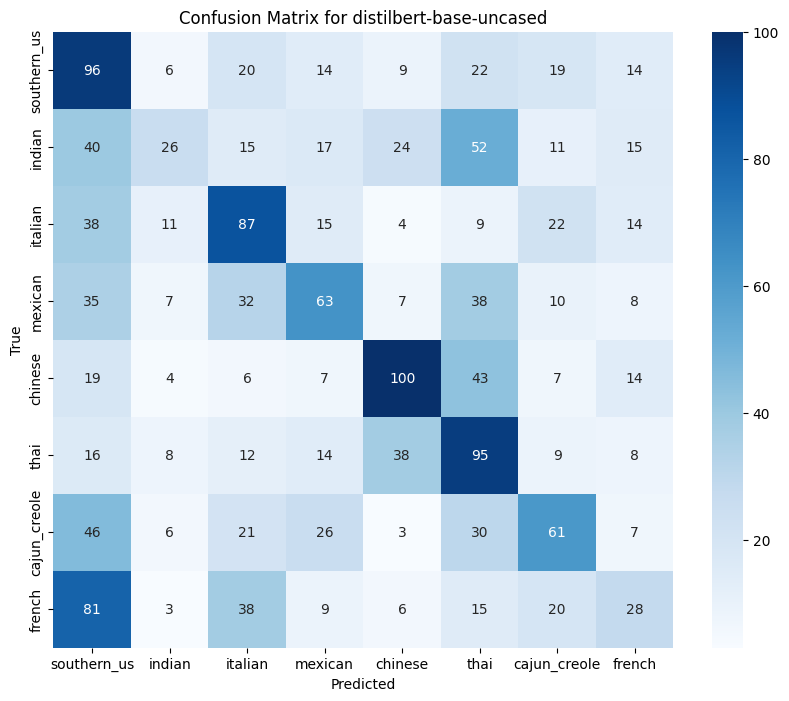

[I 2024-06-09 08:44:55,623] Trial 0 finished with value: 0.3475 and parameters: {'learning_rate': 1.4383442255151469e-05, 'batch_size': 16, 'weight_decay': 0.1}. Best is trial 0 with value: 0.3475.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.646400,1.700976,0.391875


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.27      0.35      0.31       200
      indian       0.39      0.42      0.40       200
     italian       0.36      0.49      0.41       200
     mexican       0.49      0.38      0.43       200
     chinese       0.57      0.45      0.50       200
        thai       0.47      0.47      0.47       200
cajun_creole       0.42      0.30      0.35       200
      french       0.28      0.27      0.27       200

    accuracy                           0.39      1600
   macro avg       0.41      0.39      0.39      1600
weighted avg       0.41      0.39      0.39      1600



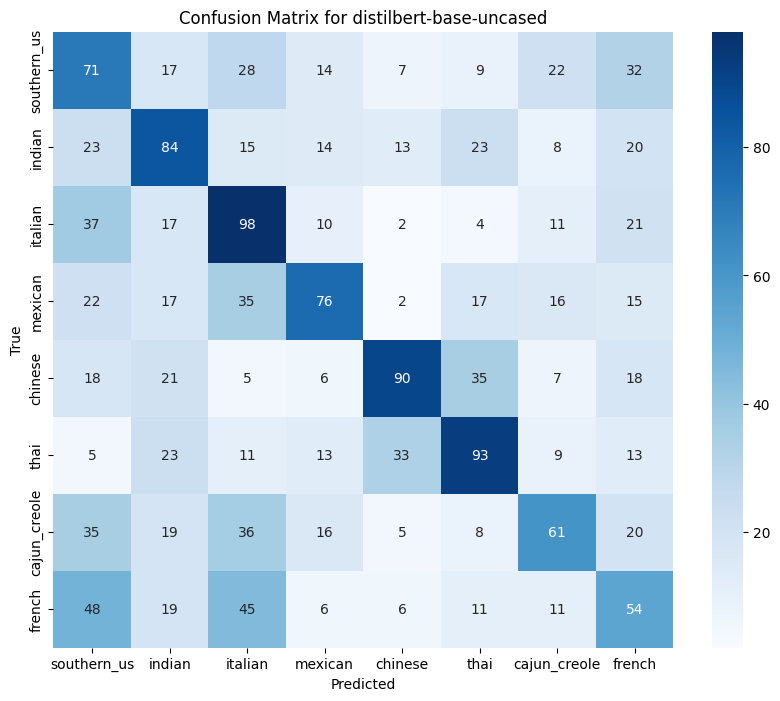

[I 2024-06-09 08:45:32,503] Trial 1 finished with value: 0.391875 and parameters: {'learning_rate': 3.6461904475865354e-05, 'batch_size': 16, 'weight_decay': 0.3}. Best is trial 1 with value: 0.391875.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.847900,1.826806,0.342500


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.25      0.47      0.33       200
      indian       0.36      0.13      0.19       200
     italian       0.37      0.43      0.40       200
     mexican       0.39      0.32      0.35       200
     chinese       0.50      0.48      0.49       200
        thai       0.32      0.47      0.38       200
cajun_creole       0.38      0.29      0.33       200
      french       0.25      0.13      0.17       200

    accuracy                           0.34      1600
   macro avg       0.35      0.34      0.33      1600
weighted avg       0.35      0.34      0.33      1600



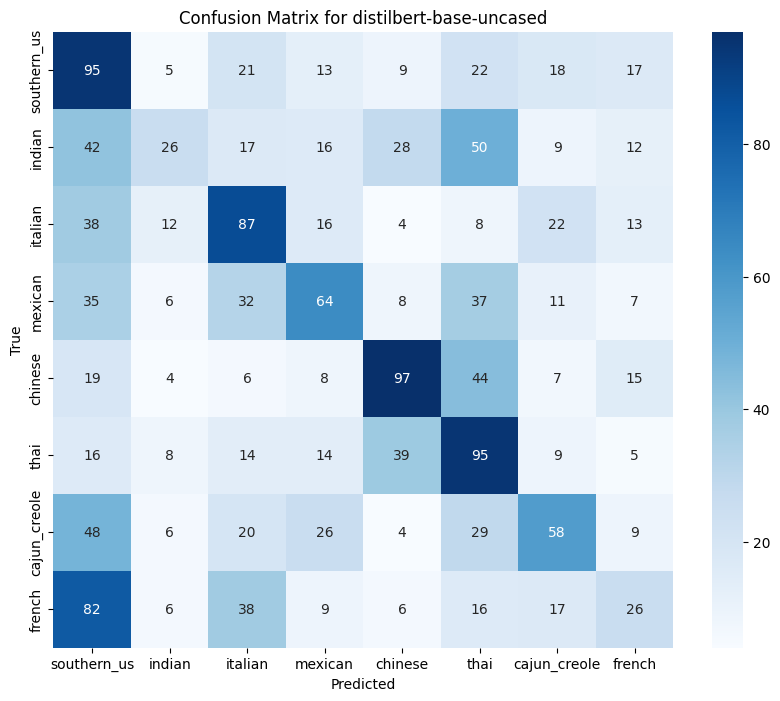

[I 2024-06-09 08:46:21,543] Trial 2 finished with value: 0.3425 and parameters: {'learning_rate': 1.4387655871029338e-05, 'batch_size': 16, 'weight_decay': 0.1}. Best is trial 1 with value: 0.391875.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.843400,1.805766,0.341875


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.26      0.25      0.25       200
      indian       0.37      0.16      0.22       200
     italian       0.35      0.56      0.43       200
     mexican       0.35      0.33      0.34       200
     chinese       0.58      0.40      0.47       200
        thai       0.31      0.54      0.39       200
cajun_creole       0.42      0.12      0.19       200
      french       0.28      0.37      0.32       200

    accuracy                           0.34      1600
   macro avg       0.37      0.34      0.33      1600
weighted avg       0.37      0.34      0.33      1600



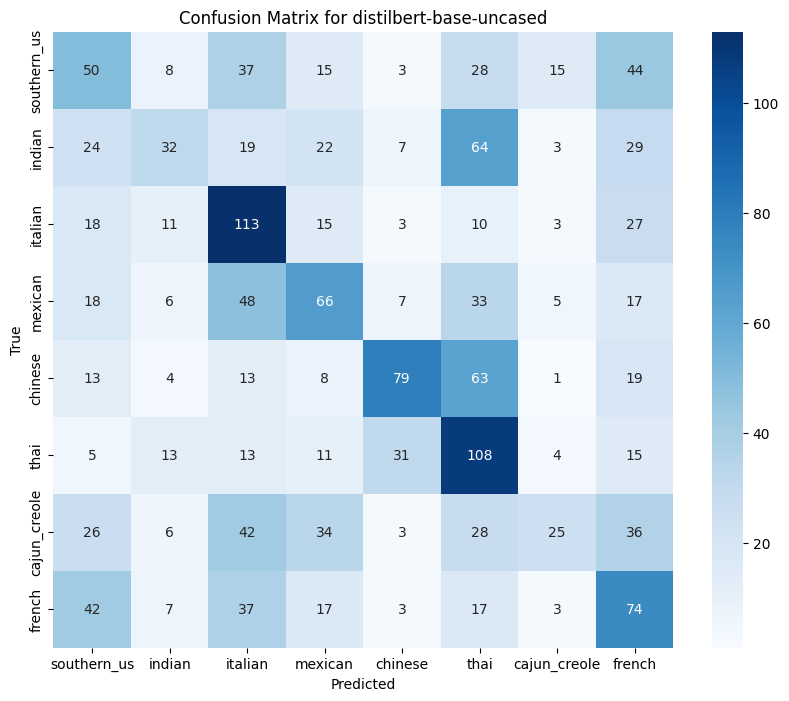

[I 2024-06-09 08:46:45,076] Trial 3 finished with value: 0.341875 and parameters: {'learning_rate': 3.357780992197934e-05, 'batch_size': 32, 'weight_decay': 0.2}. Best is trial 1 with value: 0.391875.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.823800,1.778229,0.356875


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.26      0.43      0.32       200
      indian       0.47      0.27      0.34       200
     italian       0.35      0.47      0.40       200
     mexican       0.43      0.33      0.37       200
     chinese       0.50      0.49      0.50       200
        thai       0.33      0.47      0.39       200
cajun_creole       0.36      0.24      0.29       200
      french       0.27      0.14      0.18       200

    accuracy                           0.36      1600
   macro avg       0.37      0.36      0.35      1600
weighted avg       0.37      0.36      0.35      1600



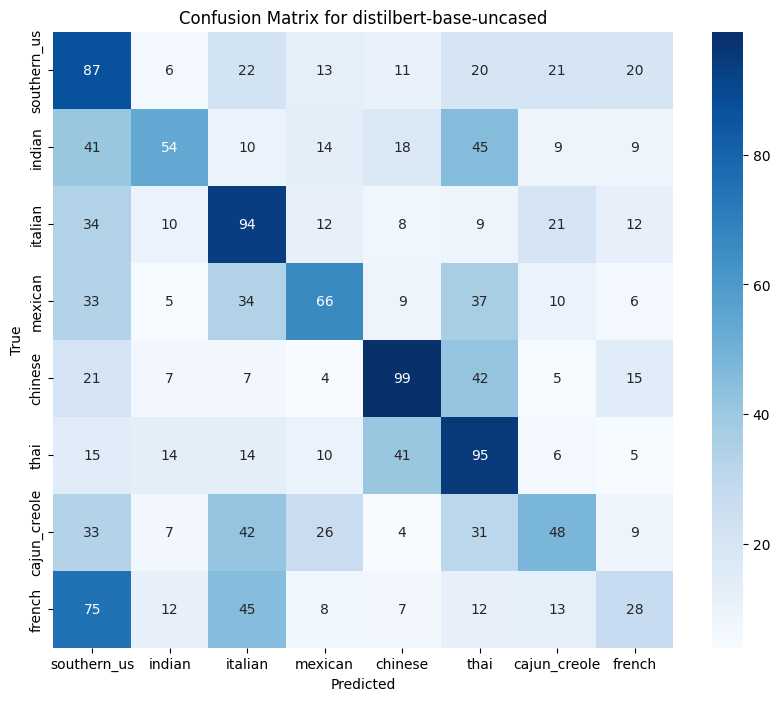

[I 2024-06-09 08:47:09,500] Trial 4 finished with value: 0.356875 and parameters: {'learning_rate': 2.9011050633596342e-05, 'batch_size': 32, 'weight_decay': 0.2}. Best is trial 1 with value: 0.391875.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.003500,1.984143,0.291875


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.25      0.39      0.30       200
      indian       1.00      0.01      0.03       200
     italian       0.30      0.29      0.30       200
     mexican       0.29      0.43      0.35       200
     chinese       0.30      0.67      0.41       200
        thai       0.57      0.07      0.12       200
cajun_creole       0.28      0.39      0.33       200
      french       0.36      0.08      0.13       200

    accuracy                           0.29      1600
   macro avg       0.42      0.29      0.25      1600
weighted avg       0.42      0.29      0.25      1600



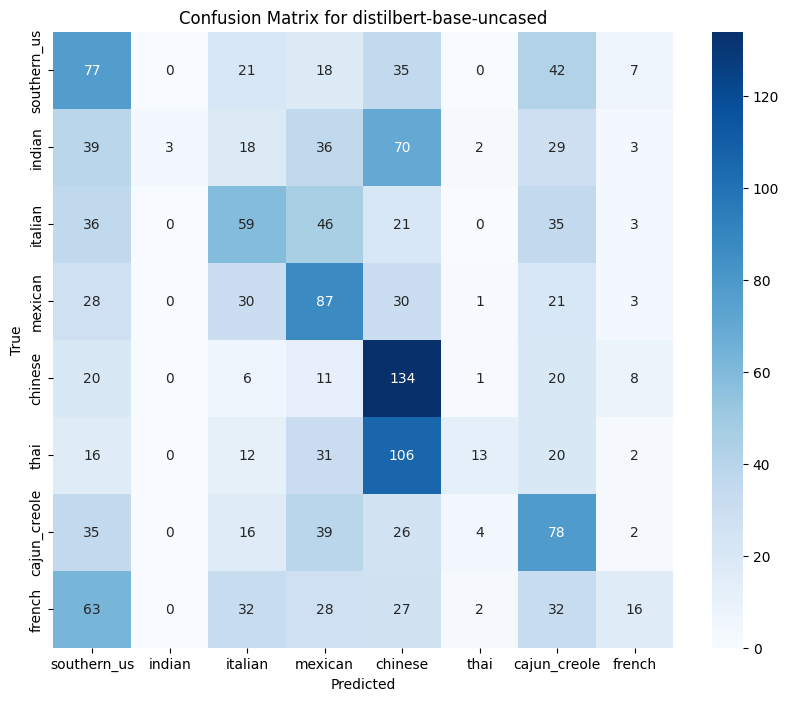

[I 2024-06-09 08:47:33,903] Trial 5 finished with value: 0.291875 and parameters: {'learning_rate': 1.1913025020786679e-05, 'batch_size': 32, 'weight_decay': 0.1}. Best is trial 1 with value: 0.391875.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.023200,2.007081,0.291250


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.23      0.28      0.26       200
      indian       1.00      0.01      0.03       200
     italian       0.38      0.26      0.31       200
     mexican       0.31      0.45      0.36       200
     chinese       0.28      0.68      0.40       200
        thai       0.56      0.07      0.13       200
cajun_creole       0.25      0.42      0.32       200
      french       0.34      0.15      0.21       200

    accuracy                           0.29      1600
   macro avg       0.42      0.29      0.25      1600
weighted avg       0.42      0.29      0.25      1600



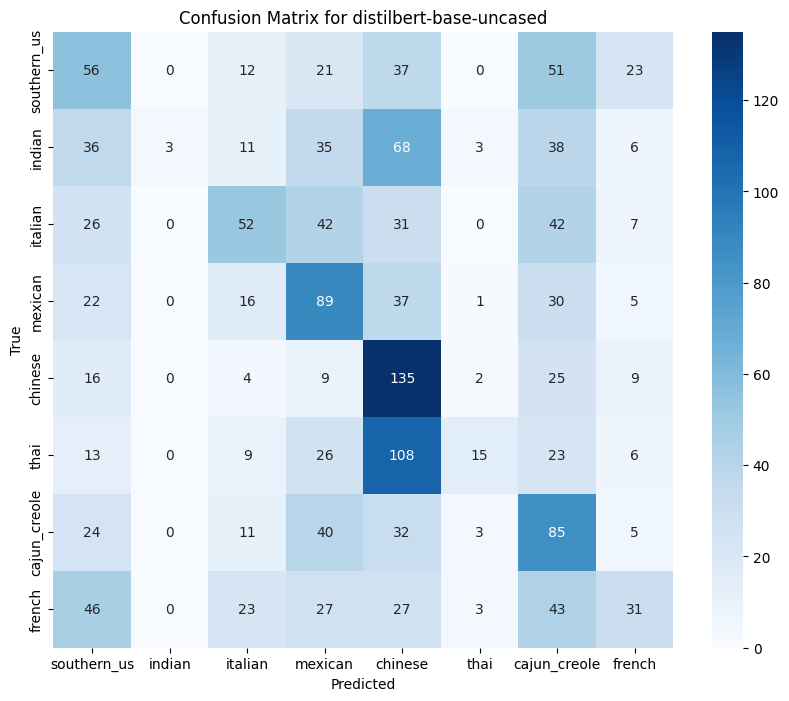

[I 2024-06-09 08:47:59,764] Trial 6 finished with value: 0.29125 and parameters: {'learning_rate': 1.0614782207597466e-05, 'batch_size': 32, 'weight_decay': 0.1}. Best is trial 1 with value: 0.391875.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.669800,1.700667,0.395000


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.27      0.29      0.28       200
      indian       0.45      0.38      0.41       200
     italian       0.38      0.48      0.43       200
     mexican       0.43      0.38      0.40       200
     chinese       0.46      0.53      0.49       200
        thai       0.47      0.42      0.44       200
cajun_creole       0.41      0.36      0.39       200
      french       0.32      0.32      0.32       200

    accuracy                           0.40      1600
   macro avg       0.40      0.40      0.39      1600
weighted avg       0.40      0.40      0.39      1600



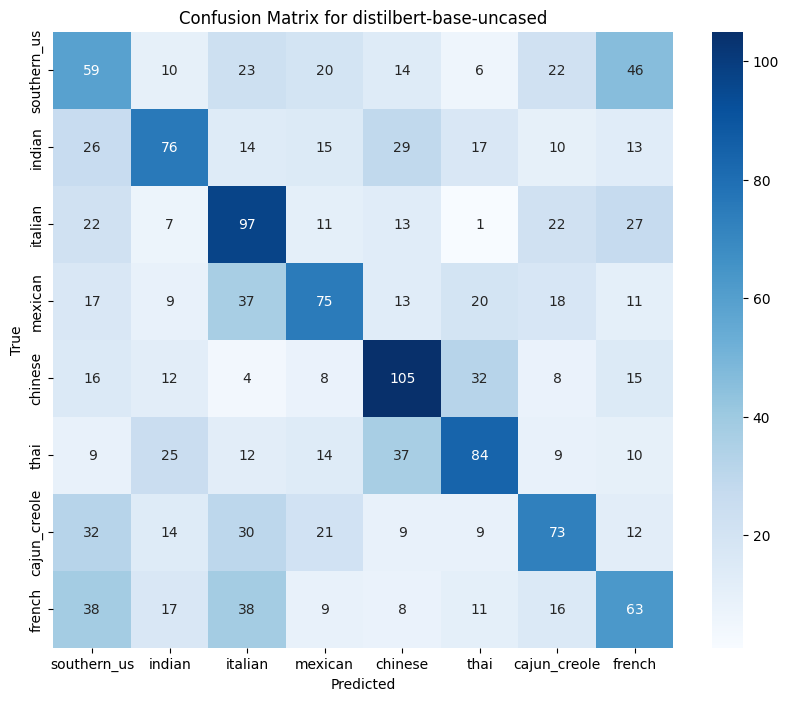

[I 2024-06-09 08:48:35,933] Trial 7 finished with value: 0.395 and parameters: {'learning_rate': 3.762306910802753e-05, 'batch_size': 16, 'weight_decay': 0.0}. Best is trial 7 with value: 0.395.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.945200,1.909153,0.328125


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.24      0.44      0.31       200
      indian       0.71      0.06      0.11       200
     italian       0.36      0.41      0.38       200
     mexican       0.38      0.43      0.41       200
     chinese       0.31      0.64      0.42       200
        thai       0.59      0.14      0.23       200
cajun_creole       0.34      0.39      0.36       200
      french       0.30      0.11      0.16       200

    accuracy                           0.33      1600
   macro avg       0.40      0.33      0.30      1600
weighted avg       0.40      0.33      0.30      1600



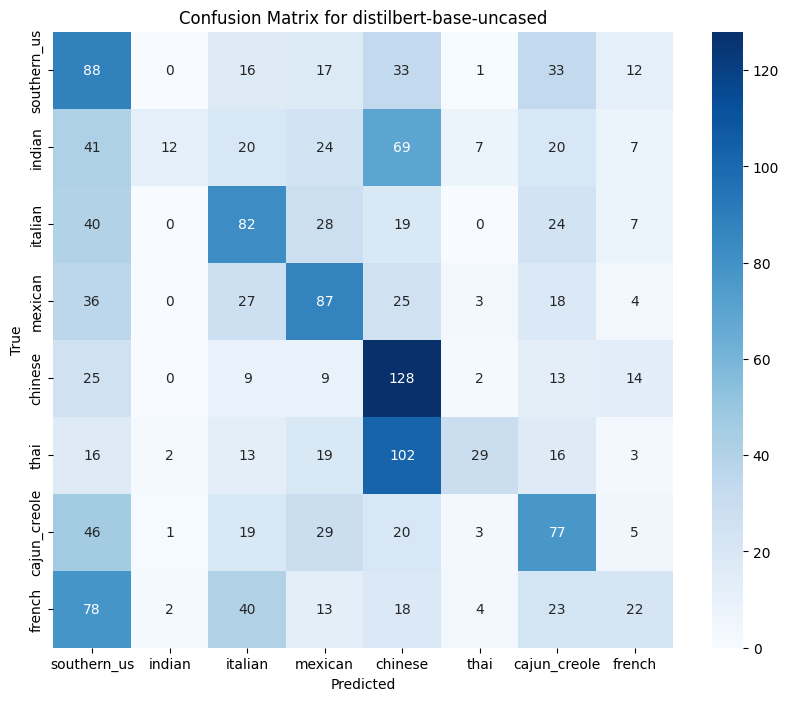

[I 2024-06-09 08:49:00,420] Trial 8 finished with value: 0.328125 and parameters: {'learning_rate': 1.617926128090333e-05, 'batch_size': 32, 'weight_decay': 0.3}. Best is trial 7 with value: 0.395.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.890100,1.843474,0.343750


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.26      0.46      0.33       200
      indian       0.51      0.10      0.16       200
     italian       0.33      0.42      0.37       200
     mexican       0.43      0.41      0.42       200
     chinese       0.35      0.59      0.44       200
        thai       0.40      0.31      0.35       200
cajun_creole       0.41      0.30      0.35       200
      french       0.27      0.15      0.20       200

    accuracy                           0.34      1600
   macro avg       0.37      0.34      0.33      1600
weighted avg       0.37      0.34      0.33      1600



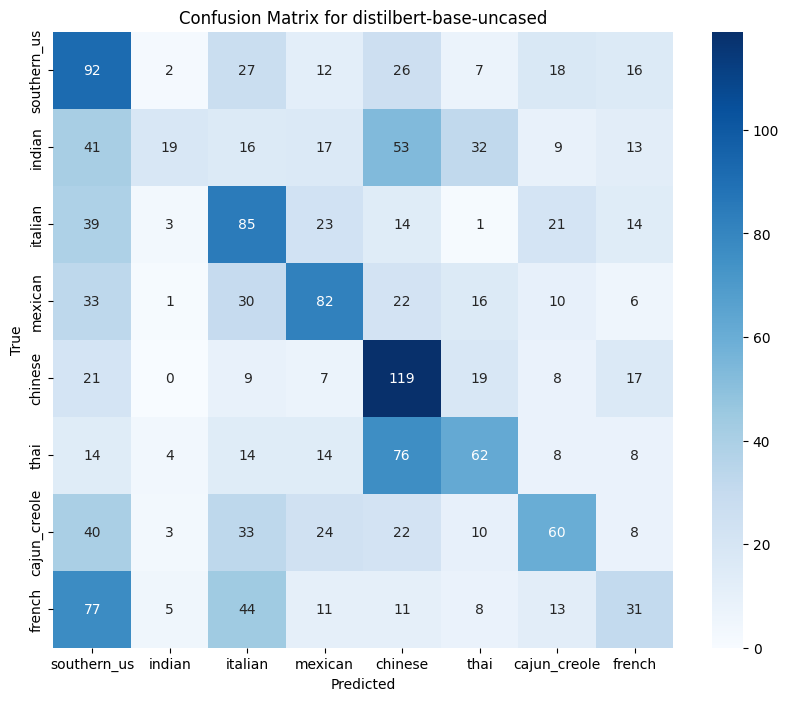

[I 2024-06-09 08:49:30,968] Trial 9 finished with value: 0.34375 and parameters: {'learning_rate': 2.188689322690112e-05, 'batch_size': 32, 'weight_decay': 0.0}. Best is trial 7 with value: 0.395.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.512800,1.612386,0.412500


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.28      0.39      0.32       200
      indian       0.51      0.44      0.47       200
     italian       0.41      0.49      0.45       200
     mexican       0.58      0.34      0.42       200
     chinese       0.48      0.51      0.50       200
        thai       0.51      0.44      0.47       200
cajun_creole       0.38      0.46      0.42       200
      french       0.29      0.23      0.25       200

    accuracy                           0.41      1600
   macro avg       0.43      0.41      0.41      1600
weighted avg       0.43      0.41      0.41      1600



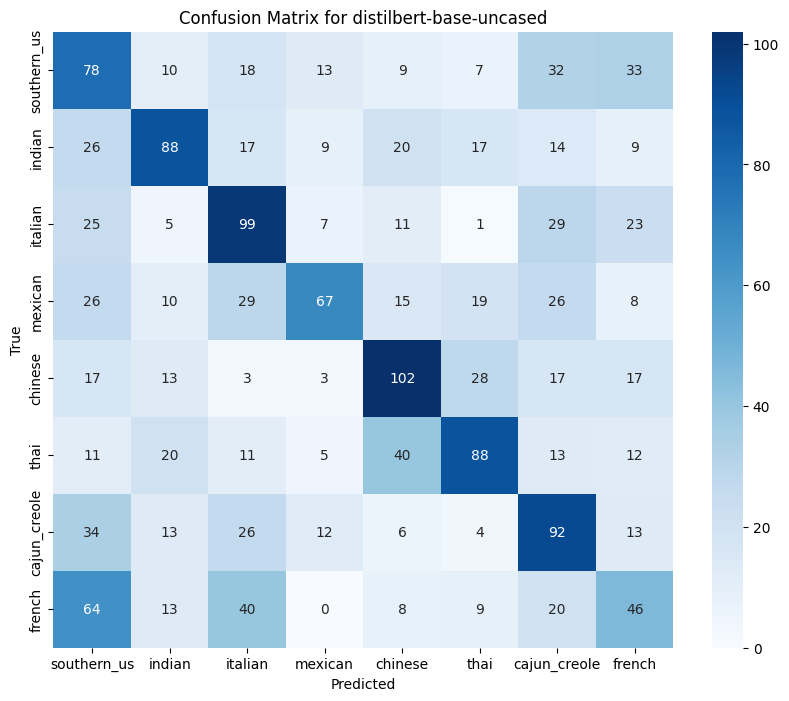

[I 2024-06-09 08:50:53,231] Trial 10 finished with value: 0.4125 and parameters: {'learning_rate': 4.922127120319222e-05, 'batch_size': 8, 'weight_decay': 0.0}. Best is trial 10 with value: 0.4125.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.569300,1.630208,0.410625


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.29      0.38      0.33       200
      indian       0.43      0.41      0.42       200
     italian       0.41      0.49      0.45       200
     mexican       0.48      0.38      0.42       200
     chinese       0.52      0.45      0.48       200
        thai       0.53      0.48      0.50       200
cajun_creole       0.39      0.46      0.42       200
      french       0.29      0.24      0.26       200

    accuracy                           0.41      1600
   macro avg       0.42      0.41      0.41      1600
weighted avg       0.42      0.41      0.41      1600



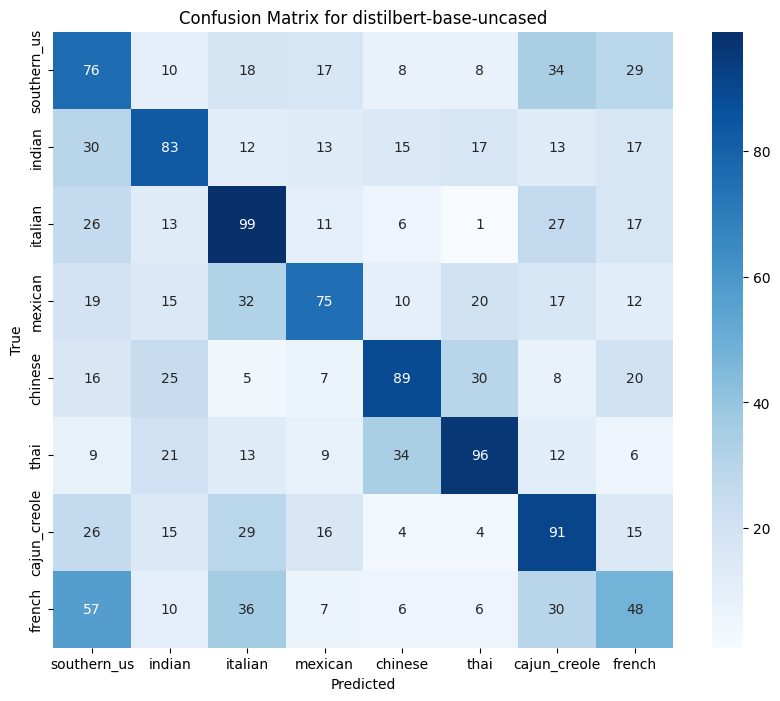

[I 2024-06-09 08:52:05,518] Trial 11 finished with value: 0.410625 and parameters: {'learning_rate': 4.3833048697386684e-05, 'batch_size': 8, 'weight_decay': 0.0}. Best is trial 10 with value: 0.4125.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.513100,1.605296,0.417500


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.27      0.34      0.30       200
      indian       0.51      0.45      0.48       200
     italian       0.42      0.50      0.46       200
     mexican       0.54      0.39      0.45       200
     chinese       0.54      0.49      0.51       200
        thai       0.51      0.43      0.47       200
cajun_creole       0.39      0.44      0.42       200
      french       0.28      0.30      0.29       200

    accuracy                           0.42      1600
   macro avg       0.43      0.42      0.42      1600
weighted avg       0.43      0.42      0.42      1600



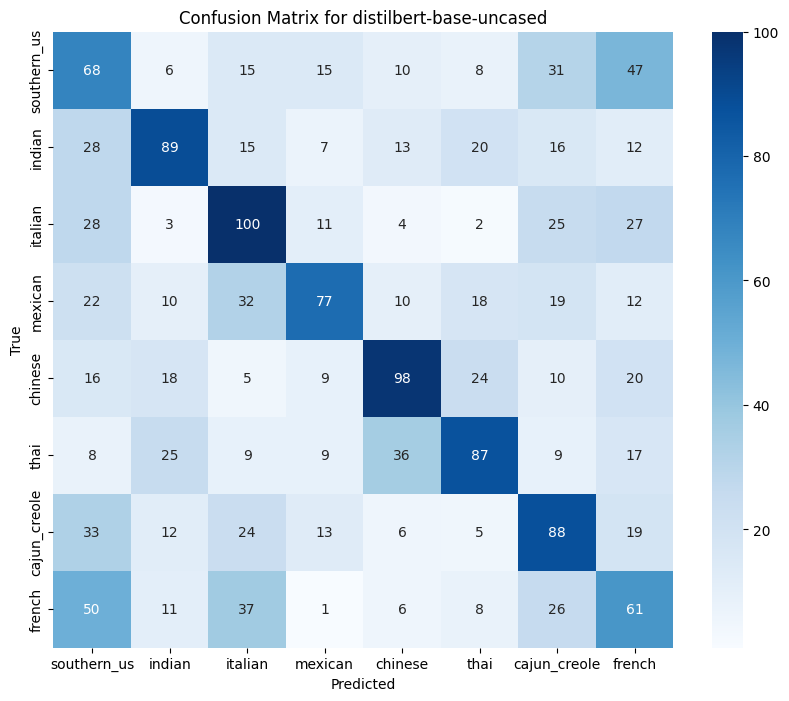

[I 2024-06-09 08:53:19,108] Trial 12 finished with value: 0.4175 and parameters: {'learning_rate': 4.853950804877155e-05, 'batch_size': 8, 'weight_decay': 0.0}. Best is trial 12 with value: 0.4175.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.533400,1.624273,0.407500


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.28      0.36      0.32       200
      indian       0.52      0.38      0.43       200
     italian       0.45      0.47      0.46       200
     mexican       0.52      0.39      0.45       200
     chinese       0.46      0.52      0.48       200
        thai       0.51      0.43      0.47       200
cajun_creole       0.36      0.46      0.41       200
      french       0.27      0.26      0.26       200

    accuracy                           0.41      1600
   macro avg       0.42      0.41      0.41      1600
weighted avg       0.42      0.41      0.41      1600



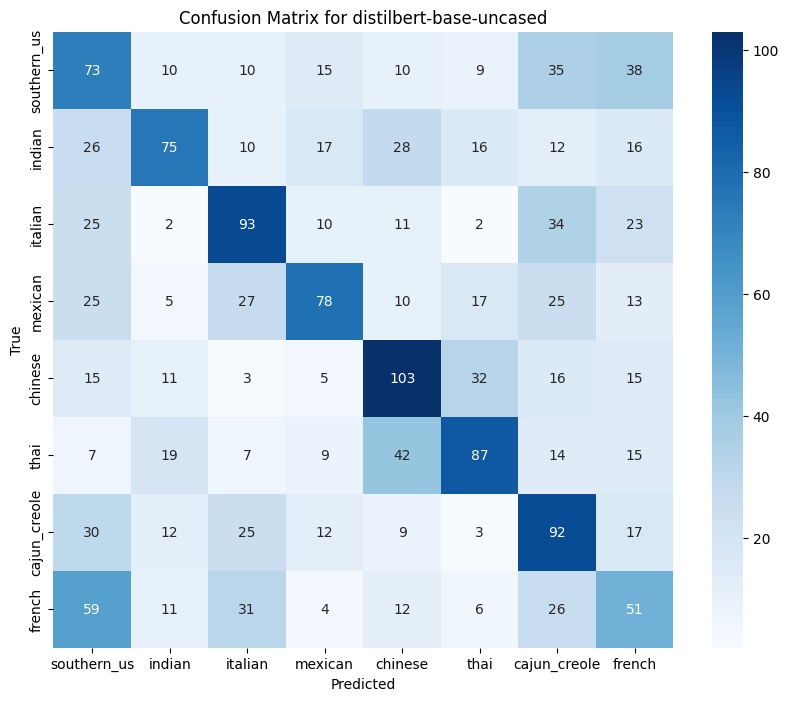

[I 2024-06-09 08:54:40,198] Trial 13 finished with value: 0.4075 and parameters: {'learning_rate': 4.6108712867862606e-05, 'batch_size': 8, 'weight_decay': 0.0}. Best is trial 12 with value: 0.4175.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.567300,1.659885,0.405625


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.25      0.32      0.28       200
      indian       0.45      0.34      0.39       200
     italian       0.43      0.48      0.45       200
     mexican       0.46      0.40      0.42       200
     chinese       0.54      0.48      0.51       200
        thai       0.48      0.47      0.48       200
cajun_creole       0.39      0.42      0.41       200
      french       0.32      0.33      0.32       200

    accuracy                           0.41      1600
   macro avg       0.41      0.41      0.41      1600
weighted avg       0.41      0.41      0.41      1600



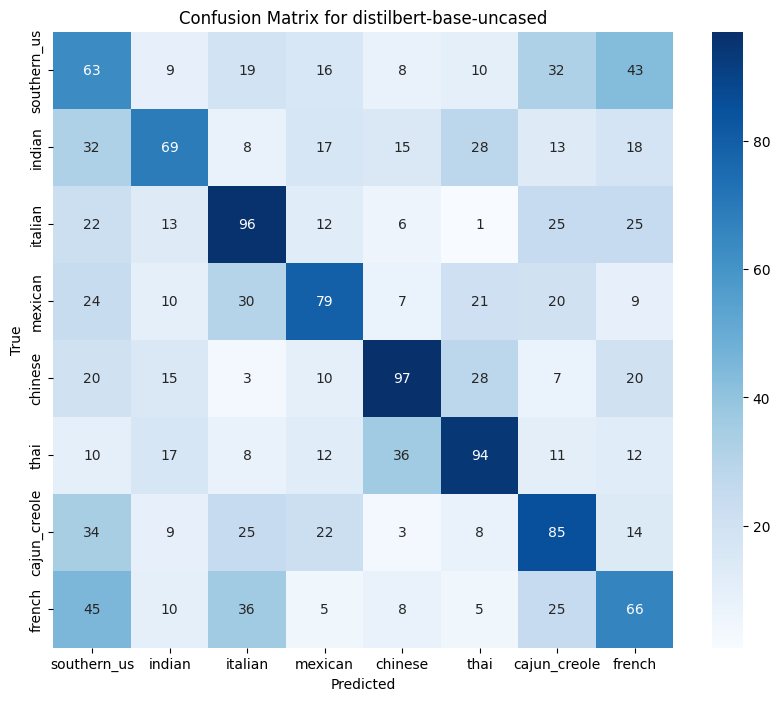

[I 2024-06-09 08:55:59,381] Trial 14 finished with value: 0.405625 and parameters: {'learning_rate': 2.5654524734843988e-05, 'batch_size': 8, 'weight_decay': 0.0}. Best is trial 12 with value: 0.4175.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.528300,1.613477,0.419375


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.30      0.30      0.30       200
      indian       0.52      0.39      0.45       200
     italian       0.39      0.48      0.43       200
     mexican       0.53      0.38      0.44       200
     chinese       0.51      0.51      0.51       200
        thai       0.52      0.45      0.48       200
cajun_creole       0.35      0.51      0.42       200
      french       0.34      0.34      0.34       200

    accuracy                           0.42      1600
   macro avg       0.43      0.42      0.42      1600
weighted avg       0.43      0.42      0.42      1600



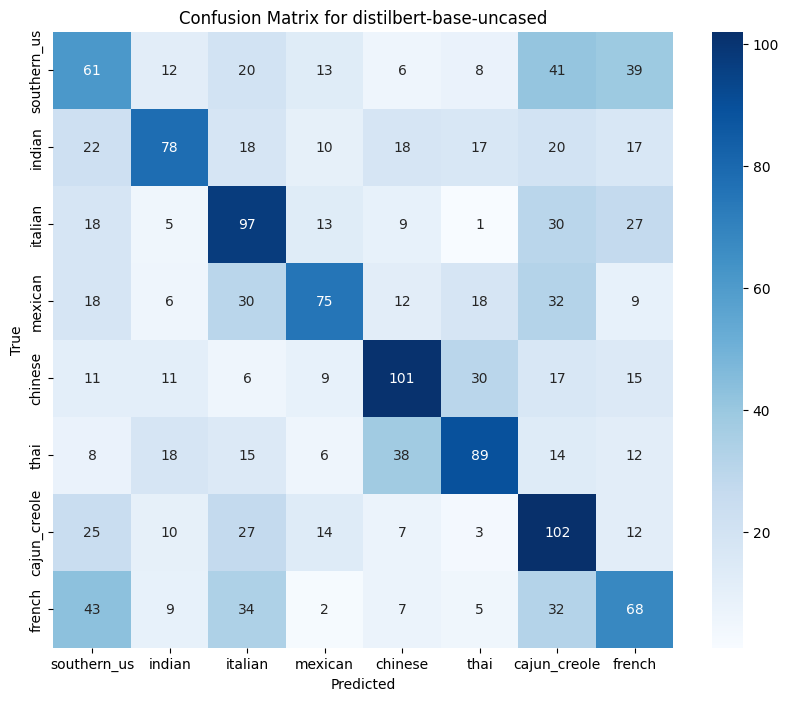

[I 2024-06-09 08:57:14,048] Trial 15 finished with value: 0.419375 and parameters: {'learning_rate': 4.957305256857996e-05, 'batch_size': 8, 'weight_decay': 0.0}. Best is trial 15 with value: 0.419375.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.621600,1.684144,0.387500


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.28      0.28      0.28       200
      indian       0.45      0.30      0.36       200
     italian       0.42      0.47      0.44       200
     mexican       0.47      0.35      0.40       200
     chinese       0.47      0.48      0.48       200
        thai       0.44      0.48      0.46       200
cajun_creole       0.36      0.36      0.36       200
      french       0.28      0.38      0.32       200

    accuracy                           0.39      1600
   macro avg       0.40      0.39      0.39      1600
weighted avg       0.40      0.39      0.39      1600



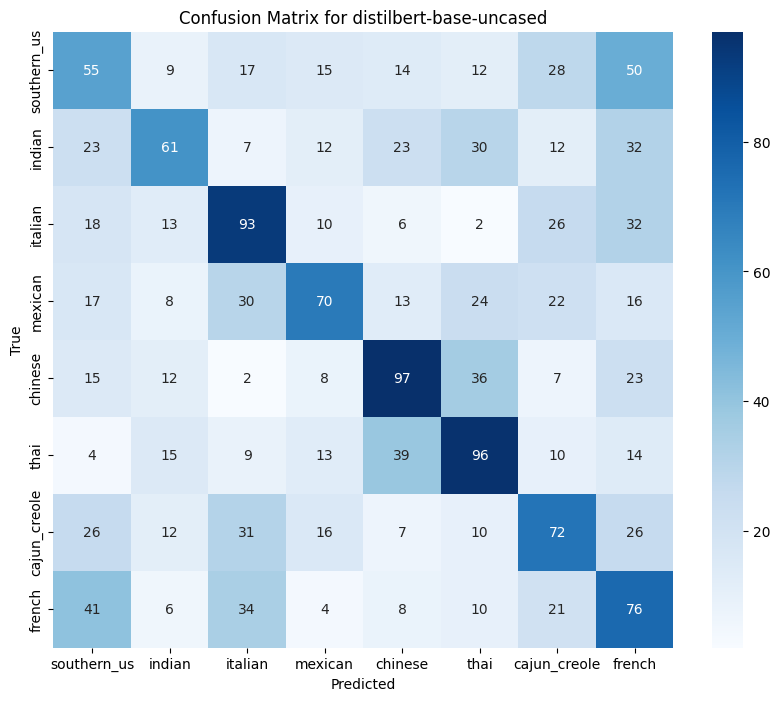

[I 2024-06-09 08:58:31,732] Trial 16 finished with value: 0.3875 and parameters: {'learning_rate': 2.001168807803046e-05, 'batch_size': 8, 'weight_decay': 0.2}. Best is trial 15 with value: 0.419375.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.572700,1.652380,0.401875


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.27      0.29      0.28       200
      indian       0.45      0.40      0.42       200
     italian       0.41      0.47      0.44       200
     mexican       0.50      0.38      0.43       200
     chinese       0.45      0.51      0.48       200
        thai       0.47      0.41      0.44       200
cajun_creole       0.39      0.41      0.40       200
      french       0.31      0.35      0.33       200

    accuracy                           0.40      1600
   macro avg       0.41      0.40      0.40      1600
weighted avg       0.41      0.40      0.40      1600



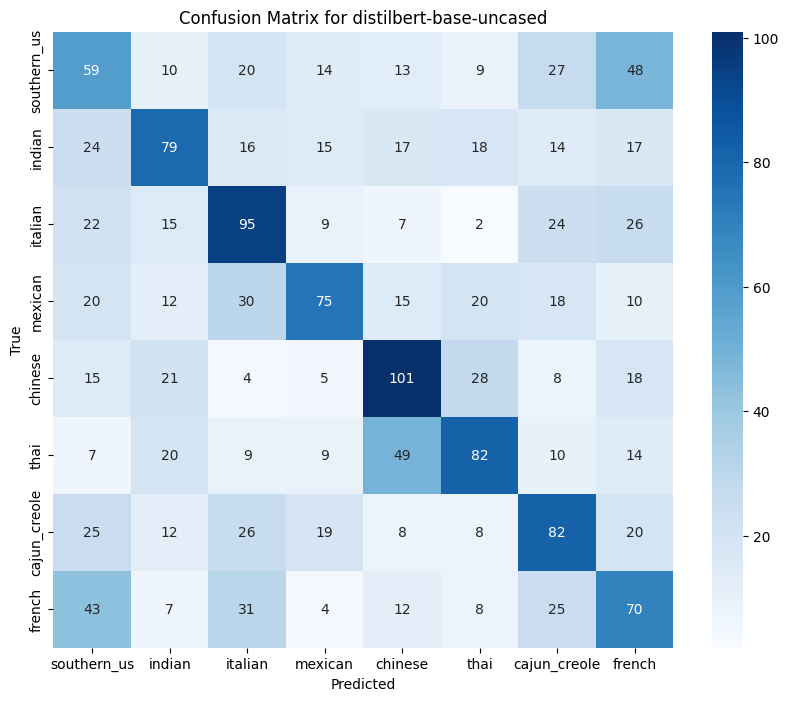

[I 2024-06-09 08:59:44,795] Trial 17 finished with value: 0.401875 and parameters: {'learning_rate': 2.991571063471948e-05, 'batch_size': 8, 'weight_decay': 0.1}. Best is trial 15 with value: 0.419375.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.527100,1.628778,0.411875


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.30      0.33      0.31       200
      indian       0.44      0.44      0.44       200
     italian       0.42      0.47      0.44       200
     mexican       0.50      0.40      0.44       200
     chinese       0.54      0.47      0.51       200
        thai       0.53      0.39      0.45       200
cajun_creole       0.36      0.48      0.41       200
      french       0.32      0.32      0.32       200

    accuracy                           0.41      1600
   macro avg       0.42      0.41      0.41      1600
weighted avg       0.42      0.41      0.41      1600



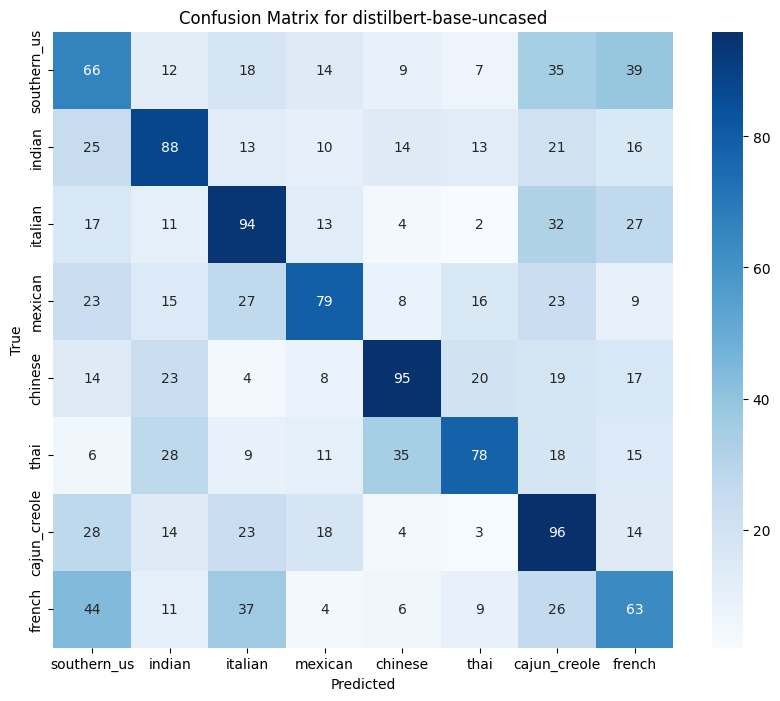

[I 2024-06-09 09:00:55,512] Trial 18 finished with value: 0.411875 and parameters: {'learning_rate': 4.215863890669787e-05, 'batch_size': 8, 'weight_decay': 0.0}. Best is trial 15 with value: 0.419375.


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.489300,1.605841,0.416250


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.27      0.32      0.29       200
      indian       0.47      0.43      0.45       200
     italian       0.43      0.51      0.46       200
     mexican       0.53      0.38      0.44       200
     chinese       0.47      0.57      0.52       200
        thai       0.57      0.38      0.46       200
cajun_creole       0.39      0.47      0.42       200
      french       0.30      0.28      0.29       200

    accuracy                           0.42      1600
   macro avg       0.43      0.42      0.42      1600
weighted avg       0.43      0.42      0.42      1600



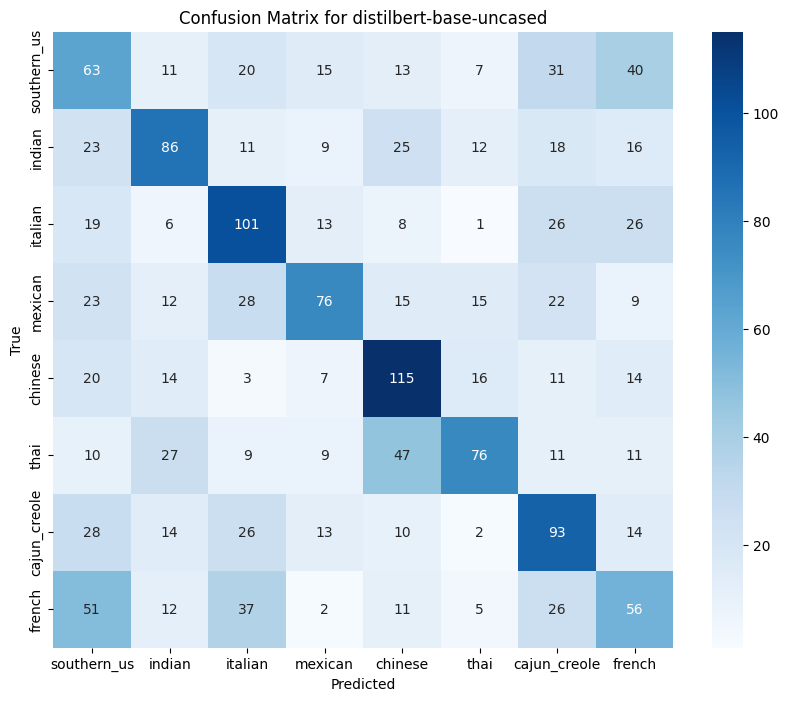

[I 2024-06-09 09:02:11,524] Trial 19 finished with value: 0.41625 and parameters: {'learning_rate': 4.9754981000262596e-05, 'batch_size': 8, 'weight_decay': 0.1}. Best is trial 15 with value: 0.419375.


Beste Hyperparameter:  {'learning_rate': 4.957305256857996e-05, 'batch_size': 8, 'weight_decay': 0.0}


In [17]:
# Define the Optuna Objective Function
def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.

    Parameters:
    trial (optuna.trial.Trial): A single optimization trial.

    Returns:
    float: The evaluation accuracy of the trained model.
    """
    # Hyperparameters to be optimized
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1, step=0.01)

    # Train the model
    model, eval_results = train_model(
        'distilbert-base-uncased',
        DistilBertForSequenceClassification,
        DistilBertTokenizer,
        num_labels,
        learning_rate=learning_rate,
        batch_size=batch_size,
        weight_decay=weight_decay,
        num_epochs=1  # For quick iterations; increase epochs for better results
    )

    # Return the accuracy for optimization
    if 'eval_accuracy' in eval_results:
        return eval_results['eval_accuracy']
    else:
        raise KeyError("eval_accuracy not found in eval_results")

# Create and Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Print Best Hyperparameters
print("Beste Hyperparameter: ", study.best_params)

##Training the Best Model with Optimized Hyperparameters

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.415800,1.622638,0.409375
2,1.580300,1.559906,0.434375
3,1.337400,1.572280,0.450000


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.36      0.38      0.37       200
      indian       0.56      0.48      0.52       200
     italian       0.43      0.52      0.47       200
     mexican       0.53      0.45      0.49       200
     chinese       0.50      0.53      0.52       200
        thai       0.48      0.41      0.44       200
cajun_creole       0.42      0.51      0.46       200
      french       0.36      0.33      0.35       200

    accuracy                           0.45      1600
   macro avg       0.45      0.45      0.45      1600
weighted avg       0.45      0.45      0.45      1600



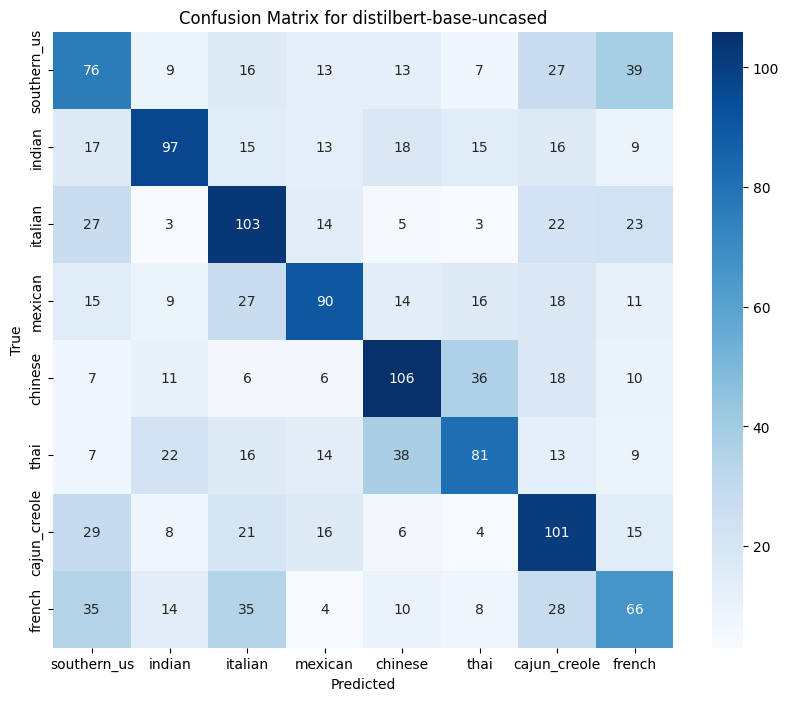

In [18]:
# Train the Best Model with Optimized Hyperparameters
best_params = study.best_params
best_distilbert_model, _ = train_model(
    'distilbert-base-uncased',
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    num_labels,
    learning_rate=best_params['learning_rate'],
    batch_size=best_params['batch_size'],
    weight_decay=best_params['weight_decay'],
    num_epochs=3
)

##Evaluate on Test Dataset Function

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Classification Report on Test Dataset:
              precision    recall  f1-score   support

 southern_us       0.47      0.54      0.50       250
      indian       0.60      0.61      0.61       250
     italian       0.49      0.58      0.53       250
     mexican       0.61      0.54      0.57       250
     chinese       0.64      0.59      0.62       250
        thai       0.64      0.54      0.58       250
cajun_creole       0.50      0.56      0.53       250
      french       0.52      0.47      0.49       250

    accuracy                           0.55      2000
   macro avg       0.56      0.55      0.55      2000
weighted avg       0.56      0.55      0.55      2000



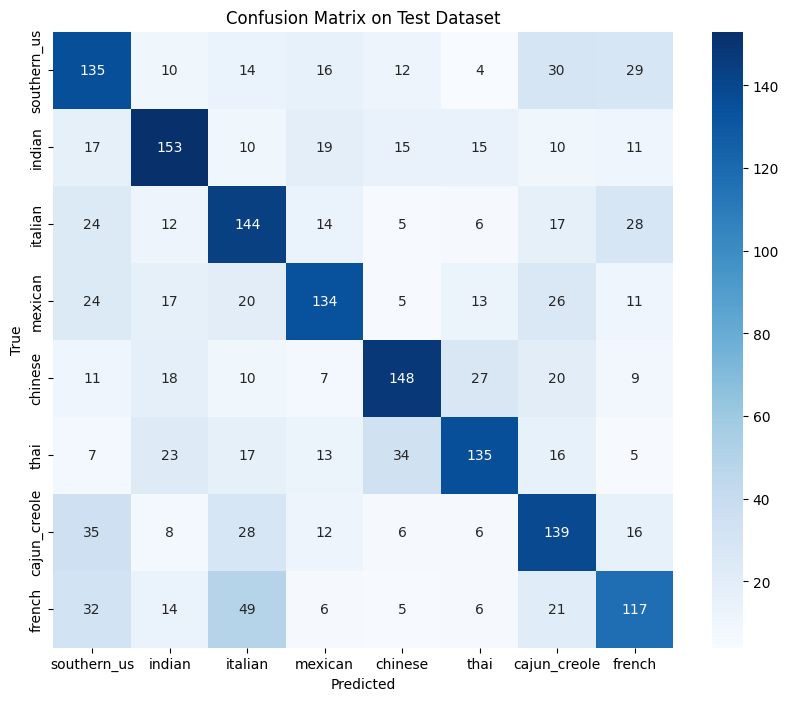

In [19]:
def evaluate_on_test_dataset(model, test_dataset):
    """
    Evaluates the trained model on the test dataset.

    Parameters:
    model (nn.Module): The trained model.
    test_dataset (Dataset): The test dataset.

    Returns:
    None
    """
    # Tokenize the test dataset
    tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

    # Create a new Trainer instance for prediction
    trainer = Trainer(model=model)

    # Make predictions on the test dataset
    test_predictions = trainer.predict(tokenized_test_dataset).predictions
    test_predictions = np.argmax(test_predictions, axis=1)
    test_labels = tokenized_test_dataset['labels']

    # Classification report
    print("Classification Report on Test Dataset:")
    print(classification_report(test_labels, test_predictions, target_names=list(label2id.keys())))

    # Confusion matrix
    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(label2id.keys()), yticklabels=list(label2id.keys()), cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix on Test Dataset')
    plt.show()

# Evaluate the best DistilBERT model on the test dataset
evaluate_on_test_dataset(best_distilbert_model, test_dataset)

##Function for Making Predictions with All Models

In [20]:
def classify_recipe(recipe):
    """
    Classifies a recipe using multiple pre-trained models.

    Parameters:
    recipe (str): The recipe to classify.

    Returns:
    dict: A dictionary with the model names as keys and the predicted cuisines as values.
    """
    print(f"Classifying recipe: {recipe}")
    inputs = tokenizer(recipe, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)

    # Remove 'token_type_ids' for DistilBERT and GPT2
    if 'token_type_ids' in inputs:
        del inputs['token_type_ids']

    predictions = {}

    # DistilBERT
    with torch.no_grad():
        outputs = distilbert_model(**inputs)
    distilbert_prediction = torch.argmax(outputs.logits, dim=1).item()
    predictions['DistilBERT'] = id2label[distilbert_prediction]

    # BERT Base
    with torch.no_grad():
        outputs = bert_base_model(**inputs)
    bert_base_prediction = torch.argmax(outputs.logits, dim=1).item()
    predictions['BERT Base'] = id2label[bert_base_prediction]

    # BERT Large
    with torch.no_grad():
        outputs = bert_large_model(**inputs)
    bert_large_prediction = torch.argmax(outputs.logits, dim=1).item()
    predictions['BERT Large'] = id2label[bert_large_prediction]

    # RoBERTa
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    roberta_prediction = torch.argmax(outputs.logits, dim=1).item()
    predictions['RoBERTa'] = id2label[roberta_prediction]

    # GPT-2
    with torch.no_grad():
        outputs = gpt2_model(**inputs)
    gpt2_prediction = torch.argmax(outputs.logits, dim=1).item()
    predictions['GPT-2'] = id2label[gpt2_prediction]

    # Optimized DistilBERT
    with torch.no_grad():
        outputs = best_distilbert_model(**inputs)
    best_distilbert_prediction = torch.argmax(outputs.logits, dim=1).item()
    predictions['Optimized DistilBERT'] = id2label[best_distilbert_prediction]

    return predictions

## Retrieve and Classify Recipe

In [21]:
def get_recipe(index):
    """
    Retrieves a recipe and its cuisine from the dataset based on the given index.

    Parameters:
    index (str): The index of the recipe in the format 'index:rest_of_string'.

    Returns:
    tuple: A tuple containing the recipe and the cuisine.
    """
    try:
        print(f"Retrieving recipe for index: {index}")
        index = int(index.split(":")[0])
        recipe = training_df.iloc[index]['ingredients']
        cuisine = training_df.iloc[index]['cuisine']
        print(f"Recipe: {recipe}, Cuisine: {cuisine}")
        return recipe, cuisine
    except Exception as e:
        print(f"Error in get_recipe: {e}")
        return "", ""

In [22]:
def get_results_for_recipe(index):
    """
    Retrieves and classifies a recipe based on the given index.

    Parameters:
    index (str): The index of the recipe in the format 'index:rest_of_string'.

    Returns:
    dict: A dictionary with classification results from multiple models and the actual cuisine.
    str: The recipe ingredients.
    """
    try:
        print(f"Selected index: {index}")
        recipe, cuisine = get_recipe(index)
        if recipe == "":
            return {"Error": "Invalid index or recipe not found"}, ""
        results = classify_recipe(recipe)
        results['Actual Cuisine'] = cuisine
        return results, recipe
    except Exception as e:
        print(f"Error in get_results_for_recipe: {e}")
        return {"Error": f"An error occurred: {e}"}, ""

## Gradio Interface for Recipe Classification

In [23]:
# Recipe Picker Dropdown
recipe_picker = gr.Dropdown(
    choices=[f"{i}: {recipe[:50]}" for i, recipe in enumerate(training_df['ingredients'])],
    label="Select a Recipe",
    interactive=True
)

# Create Gradio Interface
interface = gr.Interface(
    fn=get_results_for_recipe,
    inputs=recipe_picker,
    outputs=[gr.Json(label="Predictions"), gr.Textbox(label="Selected Recipe")],
    title="Recipe Classification"
)

# Launch Gradio Interface
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://6506298bf185c0363c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
